In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import os.path
import subprocess
import pickle
import pandas as pd
from MDAnalysis.analysis import distances
import sys
import math

# for paper, run above and [skip to bottom](#paper)

# apo states here, BFRU [below](#bfru)

## Will do this for each efflux and influx in this script, so we can keep results here and images. For efflux, go [down](#efflux)

In [2]:
indir = '../../state_by_state_running/targeted_MD/influx_apo_all_heavy/OutOpen-InOpen'

u = mda.Universe(f'{indir}/OUT.equilib.200ns.gro',\
                           f'{indir}/OutOpen-InOpen.TMD_only.noskip.xtc')

In [3]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

In [13]:
gate_EC_dists = []
gate_IC_dists = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists = np.array(gate_EC_dists)
gate_IC_dists = np.array(gate_IC_dists)

Plot the entire trajectory first

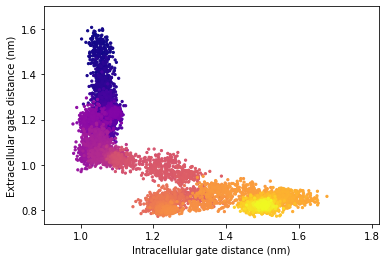

In [14]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists, gate_EC_dists, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-6-79598c868f16>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-6-79598c868f16>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

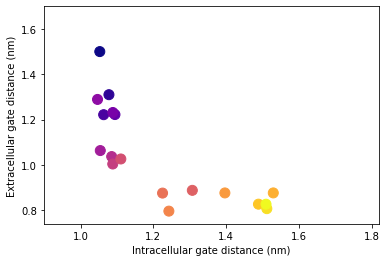

In [6]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Influx:

**Out Open - Out Occ** - 10550ps (frame 0 - 2637)


**Out Occ - Occ** - 10800ps (frame 2637-5337)

**Occ - In Occ** - 7680ps (frame 5337-7257)

**In Occ - In Open** - 10770ps (frame 7257 - 9950)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2637, 5337, 7257, and ~~9950~~. (**9859** instead, is not end of sim but is closest to in open) That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 2 from Out Open - Out Occ (500 & 1000)

Take 3 from Out Occ - Occ (2800, 3200, 4200)

Take 3 from Occ - In Occ (5500, 5750, 6300)

Take 3 InOcc - In Open (7350, 7700, 9100)

Only one I am not sure of is InOcc-InOpen. If I take 8000, for this is more open on IC than IN.start.gro. Should I take this as endpoint instead??

In [86]:
out_open_purple = [0.35, 0.07, 0.64, 1] # [0.08,0.00,0.99,1.00]
out_occ_blue = [0.00,0.35,0.90,1.00]
occ_blue = [0.00,0.59,0.96,1.00]
in_occ_blue = [0.00,0.64,0.59,1.00]
in_open_green = [0.00,0.45,0.35,1.00]

interpolations = [
                  [4, out_open_purple, out_occ_blue], \
                  [5, out_occ_blue, occ_blue], \
                  [5, occ_blue, in_occ_blue], \
                  [5, in_occ_blue, in_open_green] 
                    ]

color_l = np.array([out_open_purple])

for i in interpolations:
    color_l = np.append(color_l, np.linspace(i[1], i[2], i[0])[1:], axis = 0)
    

np.shape(color_l)
#colors = [\"#4500E6\", \"#004BFA\", \"#0097f5\", \"#00a496\", \"#00735a\"]\

(16, 4)

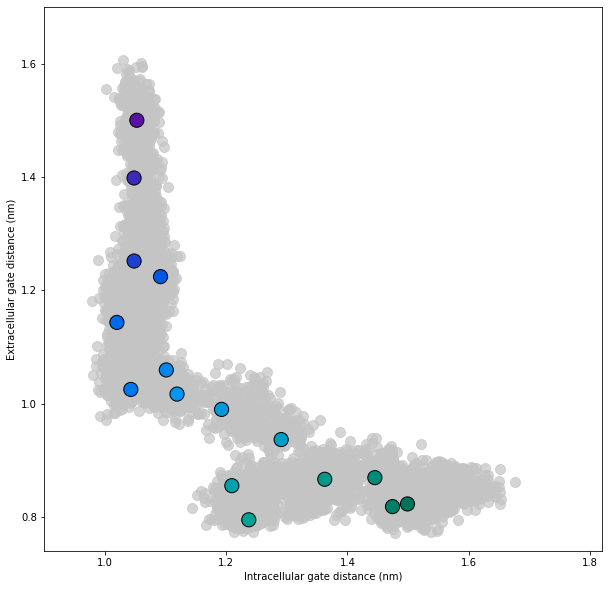

In [91]:
sarah_indices = [0, 2637, 5337, 7257, 9859,\
                 500, 1000, \
                 2800, 3200, 4200, \
                 5500, 5750, 6300, \
                7350, 7700, 9100]



f, ax = plt.subplots(figsize = (10,10))

cmap = plt.cm.get_cmap('PuBuGn')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[sarah_indices]

plt.scatter(gate_IC_dists, gate_EC_dists, color = '#C4C4C4', alpha = 0.7, s = 100)
plt.scatter(gate_IC_dists[sorted(sarah_indices)], gate_EC_dists[sorted(sarah_indices)], \
            edgecolor = 'black', s = 200, color = color_l)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

plt.savefig('../images_figs/TMD_bead_choice.apo.png', dpi = 1000)

In [8]:
sarah_indices_influx = sarah_indices
IC_inf = gate_IC_dists
EC_inf = gate_EC_dists

<a id='efflux'></a>


## Efflux simulations. Same process as above

In [9]:
indir = '../../state_by_state_running/targeted_MD/efflux_apo_all_heavy/InOpen-OutOpen'

u = mda.Universe(f'{indir}/IN.start.gro',\
                           f'{indir}/InOpen-OutOpen.xtc')

In [10]:
gate_EC_dists = []
gate_IC_dists = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists = np.array(gate_EC_dists)
gate_IC_dists = np.array(gate_IC_dists)


Plot the entire trajectory first:

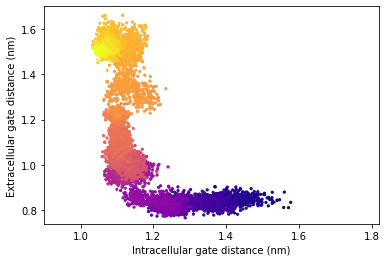

In [11]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists, gate_EC_dists, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-12-79598c868f16>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-12-79598c868f16>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

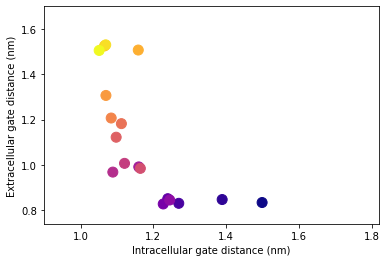

In [12]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists[[equal_indices]], gate_EC_dists[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Efflux:

**In Open - In Occ** - 9632 ps (frame 0-2407)


**In Occ - Occ** - 8628 ps (frame 2407-4563)

**Occ - Out Occ** - 7772 ps (frame 4563-6505)

**Out Occ - Out Open** - 9136 ps (frame 6505-8789)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2407, 4563, 6505, and 8789. That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 3 from InOpen-InOcc (300, 750, 1200)

Take 3 from InOcc-Occ (2600, 3000, 3800)

Take 3 from Occ-OutOcc (5170, 5300, 5700) This one is weird I know, was difficult to get out of occ-outocc, took quite a bit of pushing until EC gate opened

Take 2 from OutOcc-OutOpen (6705, 6850)

In [13]:
len(gate_IC_dists)

8789

Text(0.5, 0, 'Intracellular gate distance (nm)')

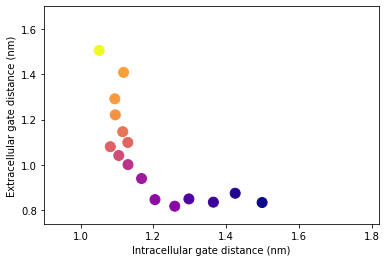

In [14]:
sarah_indices = [0, 2407, 4563, 6505, 8788,\
                300, 750, 1200,\
                2600, 3000, 3800,\
                5170, 5300, 5700, \
                6705, 6850]

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists)))
colormap = colormap[sarah_indices]

plt.scatter(gate_IC_dists[sarah_indices], gate_EC_dists[sarah_indices], s = 100, color = colormap)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

In [15]:
sarah_indices_efflux = sarah_indices
IC_eff = gate_IC_dists
EC_eff = gate_EC_dists

Write out these indices for gmx trjconv selections

In [16]:
sarah_indices_efflux = np.array(sarah_indices_efflux)
sarah_indices_influx = np.array(sarah_indices_influx)

print("INFLUX timestamps:", np.sort(sarah_indices_influx) * 4)
print("EFFLUX timestamps:", np.sort(sarah_indices_efflux) * 4)

INFLUX timestamps: [    0  2000  4000 10548 11200 12800 16800 21348 22000 23000 25200 29028
 29400 30800 36400 39436]
EFFLUX timestamps: [    0  1200  3000  4800  9628 10400 12000 15200 18252 20680 21200 22800
 26020 26820 27400 35152]


Now plot the two gates with each other:

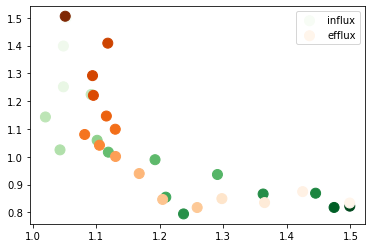

In [17]:
cmap = plt.cm.get_cmap('Greens')
colormap = cmap(np.linspace(0,1, len(IC_inf)))
colormap = colormap[sarah_indices_influx]

plt.scatter(IC_inf[sarah_indices_influx], EC_inf[sarah_indices_influx], s = 100, color = colormap, label = 'influx')




cmap = plt.cm.get_cmap('Oranges')
colormap = cmap(np.linspace(0,1, len(IC_eff)))
colormap = colormap[sarah_indices_efflux]

plt.scatter(IC_eff[sarah_indices_efflux], EC_eff[sarah_indices_efflux], s = 100, color = colormap, label = 'efflux')
plt.legend()

In [18]:
target_IC_inf = np.where(np.logical_and(IC_inf>=1.4987, IC_inf<=1.499))
target_IC_inf

(array([8337, 8462, 8474, 8612, 8638, 8717, 9360, 9515, 9643, 9743, 9806,
        9859, 9895]),)

In [19]:
print(IC_inf[9859], EC_inf[9859], '"In open" influx')
print(IC_inf[9895], EC_inf[9895], '"In open" influx')
print(IC_eff[0], EC_eff[0], 'Actual in open')

#OK so from this analysis, we know now to actually take a different coordinate for sarah_indices_influx

1.4989836041951405 0.8227302016429798 "In open" influx
1.4989499207772619 0.8107581347156531 "In open" influx
1.4987937086433547 0.8339083675081197 Actual in open


In [20]:
sarah_indices_influx 

array([   0, 2637, 5337, 7257, 9859,  500, 1000, 2800, 3200, 4200, 5500,
       5750, 6300, 7350, 7700, 9100])

<a id='bfru'></a>


# BFRU sims

I have updated the methods in how I do these gate calculations but for consistency I am going to use the same method as above

## influx

In [2]:
indir = '../../state_by_state_running/targeted_MD/influx_BFRU_all_heavy/OutOpen-InOpen'

u = mda.Universe(f'{indir}/OUT.equilib.200ns.BFRU.equilibrated.gro',\
                           f'{indir}/OutOpen-InOpen.xtc')

In [3]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

In [4]:
gate_EC_dists_inf = []
gate_IC_dists_inf = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists_inf.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists_inf.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists_inf = np.array(gate_EC_dists_inf)
gate_IC_dists_inf = np.array(gate_IC_dists_inf)

Plot the entire trajectory first

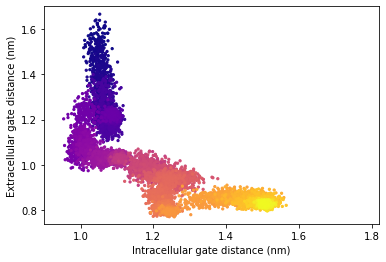

In [5]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_inf)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists_inf, gate_EC_dists_inf, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-6-0675d0e67dea>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-6-0675d0e67dea>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists_inf[[equal_indices]], gate_EC_dists_inf[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

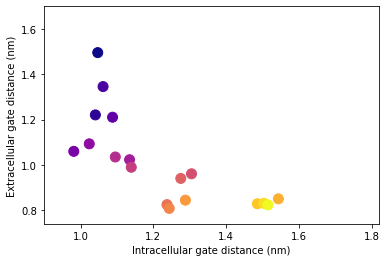

In [6]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists_inf)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_inf)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists_inf[[equal_indices]], gate_EC_dists_inf[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Influx BFRU:

**Out Open - Out Occ** - 8512ps (frame 0 - 2127)


**Out Occ - Occ** - 10800ps (frame 2127-4826) (2700frames)

**Occ - In Occ** - 12640ps (frame 4826-7985) (3160 frames)

**In Occ - In Open** -10264ps (frame 7985 - 10551) (2566 frames)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2127, 4826,7985, 10550


Take 2 from Out Open - Out Occ ( 300 & 500)

Take 3 from Out Occ - Occ (2250 , 3000, 3200)

Take 3 from Occ - In Occ (4900, 5000, 6300 )

Take 3 InOcc - In Open (8030, 8400,9100 )

In [ ]:
out_open_purple = [0.35, 0.07, 0.64, 1] # [0.08,0.00,0.99,1.00]
out_occ_blue = [0.00,0.35,0.90,1.00]
occ_blue = [0.00,0.59,0.96,1.00]
in_occ_blue = [0.00,0.64,0.59,1.00]
in_open_green = [0.00,0.45,0.35,1.00]

interpolations = [
                  [4, out_open_purple, out_occ_blue], \
                  [5, out_occ_blue, occ_blue], \
                  [5, occ_blue, in_occ_blue], \
                  [5, in_occ_blue, in_open_green] 
                    ]

color_l = np.array([out_open_purple])

for i in interpolations:
    color_l = np.append(color_l, np.linspace(i[1], i[2], i[0])[1:], axis = 0)
    

np.shape(color_l)
#colors = [\"#4500E6\", \"#004BFA\", \"#0097f5\", \"#00a496\", \"#00735a\"]\

Text(0.5, 0, 'Intracellular gate distance (nm)')

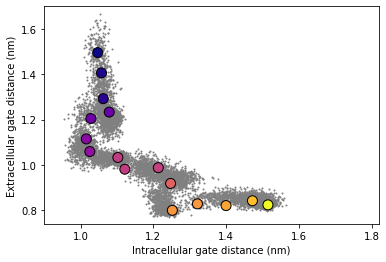

In [261]:
sarah_indices_inf = [0, 300, 500, 2127, \
                     2250, 3000, 3200, 4826, \
                     4900, 5000, 6300, 7985,\
                     8030, 8400, 9100, 10550]

#sarah_indices_inf = [0, 2127, 4826, 7985, 10550]
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_inf)))
colormap = colormap[sarah_indices_inf]

plt.scatter(gate_IC_dists_inf, gate_EC_dists_inf, s = 1, color = 'grey')
plt.scatter(gate_IC_dists_inf[sarah_indices_inf], gate_EC_dists_inf[sarah_indices_inf], s = 100, color = colormap, edgecolors='black')

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

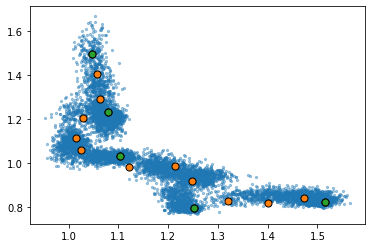

In [8]:
plt.scatter(gate_IC_dists_inf, gate_EC_dists_inf, alpha = 0.4, s = 5)
plt.scatter(gate_IC_dists_inf[sarah_indices_inf], gate_EC_dists_inf[sarah_indices_inf], s = 50, edgecolor = 'black')
plt.scatter(gate_IC_dists_inf[[0,2127,4826,7985,10550]], gate_EC_dists_inf[[0,2127,4826,7985,10550]], s = 50, edgecolor = 'black')

In [288]:
print("INFLUX timestamps:", np.sort(sarah_indices_inf) * 4)

INFLUX timestamps: [    0  1200  2000  8508  9000 12000 12800 19304 19600 20000 25200 31940
 32120 33600 36400 42200]


# Efflux BFRU

In [9]:
indir = '../../state_by_state_running/targeted_MD/efflux_BFRU_all_heavy/InOpen-OutOpen'

u = mda.Universe(f'{indir}/IN.start.BFRU.equilbrated.gro',\
                           f'{indir}/InOpen-OutOpen.xtc')

In [10]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

In [11]:
gate_EC_dists_eff = []
gate_IC_dists_eff = []

for timestep in u.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(u)

    gate_EC_dists_eff.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists_eff.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists_eff = np.array(gate_EC_dists_eff)
gate_IC_dists_eff = np.array(gate_IC_dists_eff)

Plot the entire trajectory first

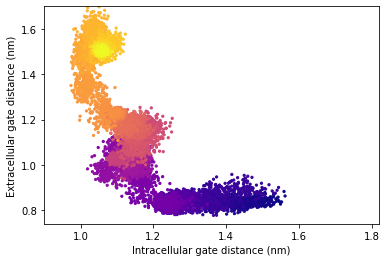

In [12]:
a = 1
s = 5
cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_eff)))


#plt.scatter(gate_IC_dists_influx[[112,220,302,408]], gate_EC_dists_influx[[112,220,302,408]],\
#            alpha = 1, color = 'green', s=100, edgecolor = 'black')

fig, ax = plt.subplots()
im = ax.scatter(gate_IC_dists_eff, gate_EC_dists_eff, alpha = a, color = colormap, s = s)
#fig.colorbar(im, ax=ax)

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")
plt.show()

Can take equal points along the sim to get your start for strings, but this is not the best idea, because sampling will be different for each chunk of TMD

<ipython-input-13-053e9e609ff0>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  colormap = colormap[[equal_indices]]
<ipython-input-13-053e9e609ff0>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  plt.scatter(gate_IC_dists_eff[[equal_indices]], gate_EC_dists_eff[[equal_indices]], s = 100, color = colormap)


Text(0.5, 0, 'Intracellular gate distance (nm)')

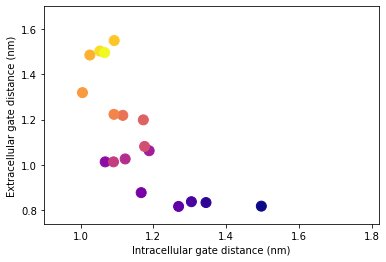

In [13]:
equal_indices = np.round(np.linspace(0, len(gate_IC_dists_eff)-1, 18))
equal_indices = np.array(equal_indices, dtype = int)

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_eff)))
colormap = colormap[[equal_indices]]

plt.scatter(gate_IC_dists_eff[[equal_indices]], gate_EC_dists_eff[[equal_indices]], s = 100, color = colormap)
plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

Efflux:

**In Open - In Occ** -  10008ps (frame 0-2501)


**In Occ - Occ** - 12992 ps (frame 2501-5748) (3248 frames)

**Occ - Out Occ** - 11784 ps (frame 5748-8693) (2946 frames)

**Out Occ - Out Open** - 12440 ps (frame 8693-11803) (3110 frames)

I think the best assumption is to take 4 beads from each transition. Each transition might not actually be this equal in 'real time' (ie Out Open --> Out Occ takes no time at all, but you are 'oversampling' this area by having 4 points there, but since we have no way of knowing this so we just have to try. 

The points you should take for sure are:
0, 2501, 5748, 8693, and 11803. That leaves 11 more to choose from. Try to take from start of TMD since the traj will be probably more in between the two states, whereas near the end of TMD it's very close

Take 3 from InOpen-InOcc (300, 750, 1200)

Take 3 from InOcc-Occ (2600, 2800, 4000)

Take 3 from Occ-OutOcc (5810, 7100, 7500) 

Take 2 from OutOcc-OutOpen (8900, 9000)

Text(0.5, 0, 'Intracellular gate distance (nm)')

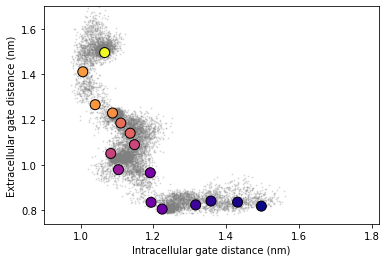

In [286]:
sarah_indices_eff = [0,200, 600, 1100, 2501,\
                     2600, 2800, 4000, 5748,\
                       5810, 7100, 7500, 8693, \
                     8900, 9000, 11802]

cmap = plt.cm.get_cmap('plasma')
colormap = cmap(np.linspace(0,1, len(gate_IC_dists_eff)))
colormap = colormap[sarah_indices_eff]

plt.scatter(gate_IC_dists_eff, gate_EC_dists_eff, alpha = 0.2, s = 1, color = 'grey')
plt.scatter(gate_IC_dists_eff[sarah_indices_eff], gate_EC_dists_eff[sarah_indices_eff], s = 100, color = colormap, edgecolors='black')

plt.xlim(0.9,1.82)
plt.ylim(0.74, 1.7)
plt.ylabel("Extracellular gate distance (nm)")
plt.xlabel("Intracellular gate distance (nm)")

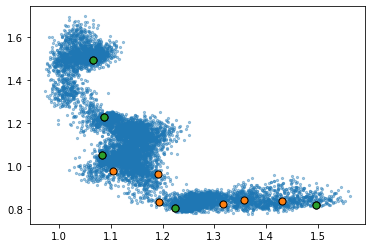

In [15]:
plt.scatter(gate_IC_dists_eff, gate_EC_dists_eff, alpha = 0.4, s = 5)
plt.scatter(gate_IC_dists_eff[sarah_indices_eff], gate_EC_dists_eff[sarah_indices_eff], s = 50, edgecolor = 'black')
plt.scatter(gate_IC_dists_eff[[0,2501,5748,8693,11802]], gate_EC_dists_eff[[0,2501,5748,8693,11802]], s = 50, edgecolor = 'black')

In [289]:
print("EFFLUX timestamps:", np.sort(sarah_indices_eff) * 4)

EFFLUX timestamps: [    0   800  2400  4400 10004 10400 11200 16000 22992 23240 28400 30000
 34772 35600 36000 47208]


In [16]:

#plt.scatter(np.arange(len(gate_EC_dists_eff)), gate_EC_dists_eff, s = 1, alpha = 0.3)
#plt.scatter(np.arange(len(gate_EC_dists_eff))[sarah_indices_eff], gate_EC_dists_eff[sarah_indices_eff])


#plt.scatter(np.arange(len(gate_IC_dists_eff)), gate_IC_dists_eff, s = 1, alpha = 0.3)
#plt.scatter(np.arange(len(gate_IC_dists_eff))[sarah_indices_eff], gate_IC_dists_eff[sarah_indices_eff])

Trying to take more equally interspaced points along the CV traj so I am not biasing it myself

In [191]:
import pandas as pd

In [192]:
arr = np.vstack((gate_IC_dists_eff, gate_EC_dists_eff)).T
df = pd.DataFrame(arr, columns=["IC_dists", "EC_dists"])

#d = pd.DataFrame(gate_IC_dists_eff.T, columns = ["IC_dists"])

First have to define intervals to take, as sometimes the TMD "overshoots" the target gate dist a bit

In [194]:
max_IC, min_IC = gate_IC_dists_eff[[0, 11802]]  #efflux, so at 0 the IC will be most open
min_EC, max_EC = gate_EC_dists_eff[[0, 11802]]  #efflux, so at 0 the EC will be most closed
#pd.cut(df['IC_dists'], bins=4)

n_bins = 8

cats_IC, bins_IC = pd.cut(df['IC_dists'], bins=np.linspace(min_IC, max_IC, n_bins), retbins=True)
cats_EC, bins_EC = pd.cut(df['EC_dists'], bins=np.linspace(min_EC, max_EC, n_bins), retbins=True)


#d['IC_dists'].value_counts(bins=np.linspace(min_IC, max_IC, 16), sort = False)
#.value_counts()
print(bins_IC,'\n', bins_EC)

[1.22415064 1.26308101 1.30201137 1.34094174 1.37987211 1.41880247
 1.45773284 1.49666321] 
 [0.80486689 0.80673252 0.80859816 0.81046379 0.81232943 0.81419506
 0.8160607  0.81792633]


2501
1920
1261
866
1107
310
115
0
7991
8701
9135
9021
8982
9181
10065
9523


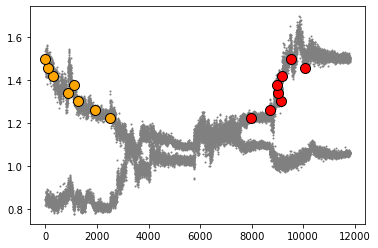

In [195]:
bins_IC_indices = []
for dist in bins_IC:
    num, ndx = find_nearest(gate_IC_dists_eff, dist)
    bins_IC_indices.append(int(ndx[0][0]))
    print(int(ndx[0][0]))

bins_EC_indices = []
for dist in bins_IC:
    num, ndx = find_nearest(gate_EC_dists_eff, dist)
    bins_EC_indices.append(int(ndx[0][0]))
    print(int(ndx[0][0]))

    
plt.scatter(range(len(gate_IC_dists_eff)), gate_IC_dists_eff, s = 1, color = 'grey')
plt.scatter(bins_IC_indices, gate_IC_dists_eff[bins_IC_indices], edgecolors='black', s = 100, color = 'orange')

plt.scatter(range(len(gate_EC_dists_eff)), gate_EC_dists_eff, s = 1, color = 'grey')
plt.scatter(bins_EC_indices, gate_EC_dists_eff[bins_EC_indices], edgecolors='black', s = 100, color = 'red')


Plotting both together:

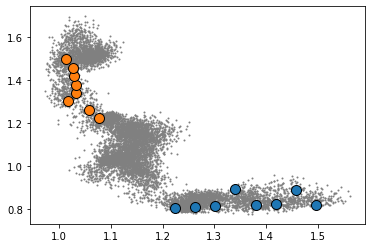

In [196]:
plt.scatter(gate_IC_dists_eff, gate_EC_dists_eff, s= 1, color = 'grey')
plt.scatter(gate_IC_dists_eff[bins_IC_indices], gate_EC_dists_eff[bins_IC_indices], s = 100, edgecolor = 'black')
plt.scatter(gate_IC_dists_eff[bins_EC_indices], gate_EC_dists_eff[bins_EC_indices], s = 100, edgecolor = 'black')

Let's try equal width binning on the difference between EC and IC

This is for efflux sims, so in open --> out open. this means EC - IC should be negative in the beginning, and become positive

In [249]:
gate_delta_D = gate_EC_dists_eff - gate_IC_dists_eff

df = pd.DataFrame(gate_delta_D, columns=["Delta_d"])


frames = [(0, 2501), (2501, 5748), (5748,8693), (8693, 11802)]
total_delta_bins = []
for start_frame, stop_frame in frames:
    min_d, max_d = gate_delta_D[[start_frame, stop_frame]]  #efflux, so at 0 the EC will be most closed
    n_bins = 5

    cats, bins = pd.cut(df['Delta_d'], bins=np.linspace(min_d, max_d, n_bins), retbins=True)
    #cats, bins = pd.cut(df['Delta_d'], bins=n_bins, retbins=True)

    delta_bins = []
    for dist in bins:
        num, ndx = find_nearest(gate_delta_D, dist)
        delta_bins.append(int(ndx[0][0]))
        print(int(ndx[0][0]))
    total_delta_bins.append(delta_bins)
    
total_delta_bins = np.array(total_delta_bins)
total_delta_bins.flatten()

0
254
523
1547
2501
2501
2742
2800
4757
5748
5748
6570
6921
7587
8693
8693
8727
8903
8979
11802


array([    0,   254,   523,  1547,  2501,  2501,  2742,  2800,  4757,
        5748,  5748,  6570,  6921,  7587,  8693,  8693,  8727,  8903,
        8979, 11802])

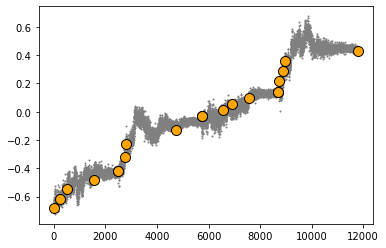

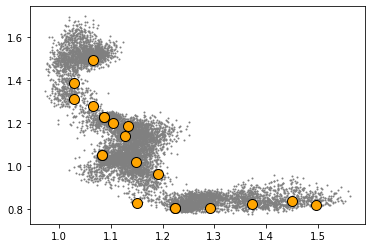

In [250]:
#plotting
plt.scatter(range(len(gate_delta_D)), gate_delta_D, s = 1, color = 'grey')
plt.scatter(total_delta_bins, gate_delta_D[total_delta_bins], edgecolors='black', s = 100, color = 'orange')
plt.show()

plt.clf()

plt.scatter(gate_IC_dists_eff, gate_EC_dists_eff, s = 1, color = 'grey')
plt.scatter(gate_IC_dists_eff[total_delta_bins], gate_EC_dists_eff[total_delta_bins], s = 100, color = 'orange', edgecolor = 'black')


In [246]:
np.unique(total_delta_bins)

array([    0,   254,   523,  1547,  2501,  2742,  2800,  4757,  5748,
        6570,  6921,  7587,  8693,  8727,  8903,  8979, 11802])

# influx bfru

In [259]:
gate_delta_D = gate_IC_dists_inf - gate_EC_dists_inf

df = pd.DataFrame(gate_delta_D, columns=["Delta_d"])

frames = [(0, 2127), (2127, 4826), (4826,7985), (7985, 10550)]
total_delta_bins = []
for start_frame, stop_frame in frames:
    min_d, max_d = gate_delta_D[[start_frame, stop_frame]]  #efflux, so at 0 the EC will be most closed
    print(min_d, max_d)
    n_bins = 5

    cats, bins = pd.cut(df['Delta_d'], bins=np.linspace(min_d, max_d, n_bins), retbins=True)
    #cats, bins = pd.cut(df['Delta_d'], bins=n_bins, retbins=True)

    delta_bins = []
    for dist in bins:
        num, ndx = find_nearest(gate_delta_D, dist)
        delta_bins.append(int(ndx[0][0]))
        print(int(ndx[0][0]))
    total_delta_bins.append(delta_bins)
    
total_delta_bins = np.array(total_delta_bins)
total_delta_bins.flatten()

-0.4486327188316548 -0.15455854607397468
0
286
329
896
2127
-0.15455854607397468 0.0696932801120429
2127
1535
2507
3623
4826
0.0696932801120429 0.45276099770582556
4826
5258
5498
6610
7985
0.45276099770582556 0.691176234253752
7985
8136
8287
8783
10550


array([    0,   286,   329,   896,  2127,  2127,  1535,  2507,  3623,
        4826,  4826,  5258,  5498,  6610,  7985,  7985,  8136,  8287,
        8783, 10550])

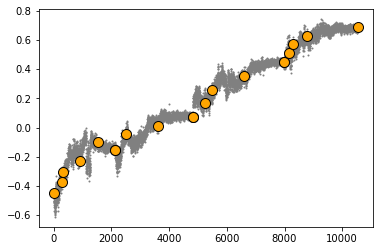

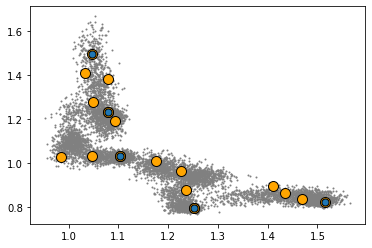

In [255]:
#plotting
plt.scatter(range(len(gate_delta_D)), gate_delta_D, s = 1, color = 'grey')
plt.scatter(total_delta_bins, gate_delta_D[total_delta_bins], edgecolors='black', s = 100, color = 'orange')
plt.show()

plt.clf()

plt.scatter(gate_IC_dists_inf, gate_EC_dists_inf, s = 1, color = 'grey')
plt.scatter(gate_IC_dists_inf[total_delta_bins], gate_EC_dists_inf[total_delta_bins], s = 100, color = 'orange', edgecolor = 'black')
plt.scatter(gate_IC_dists_inf[[0,2127,4826,7985,10550]], gate_EC_dists_inf[[0,2127,4826,7985,10550]], s = 50, edgecolor = 'black')

In [246]:
np.unique(total_delta_bins)

array([    0,   254,   523,  1547,  2501,  2742,  2800,  4757,  5748,
        6570,  6921,  7587,  8693,  8727,  8903,  8979, 11802])

In [258]:
a,b =gate_delta_D[[7985, 10550]]
np.linspace(a,b, 5)

array([0.452761  , 0.51236481, 0.57196862, 0.63157243, 0.69117623])

In [36]:
def get_beads_between(x, y, start_frame, end_frame, num_points):
    x_clip = x[start_frame:end_frame]
    y_clip = y[start_frame:end_frame]
    z = np.polyfit(x_clip, y_clip, 2)
    p = np.poly1d(z) 

    plt.scatter(x_clip, y_clip, s = 1, color = 'grey')
    
    x_line = np.linspace(np.min(x_clip), np.max(x_clip), 500)
    plt.plot(x_line, p(x_line), color = 'red')

    x_bead = np.linspace(np.min(x_clip), np.max(x_clip), num_points)
    plt.scatter(x_bead, p(x_bead), color = 'orange', edgecolor = 'black', s = 100)
   
    
    
    #plt.xlim(0.9,1.82)
    #plt.ylim(0.74, 1.7)
    plt.ylabel("Extracellular gate distance (nm)")
    plt.xlabel("Intracellular gate distance (nm)")

    print(f"taking {num_points} points from frame {start_frame} to {end_frame}")
    bead_guesses = np.vstack((x_bead, p(x_bead))).T
    print(bead_guesses)
    return bead_guesses
    plt.show()

In [115]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], np.where(array == array[idx])


taking 6 points from frame 2501 to 5748
[[1.01902058 0.99122938]
 [1.08493066 1.02979029]
 [1.15084074 1.00289908]
 [1.21675082 0.91055573]
 [1.2826609  0.75276027]
 [1.34857098 0.52951267]]


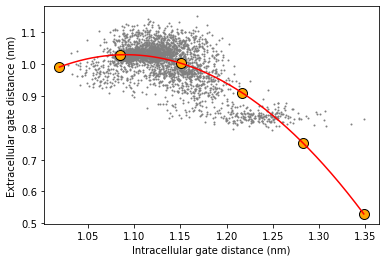

In [38]:
nearest = get_beads_between(x = gate_IC_dists_eff, y = gate_EC_dists_eff, start_frame = 2501, end_frame = 5748, num_points = 6)

In [39]:
arr = np.vstack((gate_IC_dists_eff, gate_EC_dists_eff)).T
arr

array([[1.49666321, 0.81792633],
       [1.51966226, 0.84632293],
       [1.50906409, 0.84135573],
       ...,
       [1.06082328, 1.48659557],
       [1.06197865, 1.49374261],
       [1.0661577 , 1.49595204]])

In [40]:
n = nearest[0]
from scipy import spatial
test_near = []
for n in nearest:
    distance,index = spatial.KDTree(arr).query(n)
    print(distance,index)
    test_near.append(index)

0.008742832387651056 3509
0.0005061449692397831 5623
0.0011011853638206793 3932
0.00816500052499118 2823
0.03281711063951441 1400
0.2483914532655307 1110


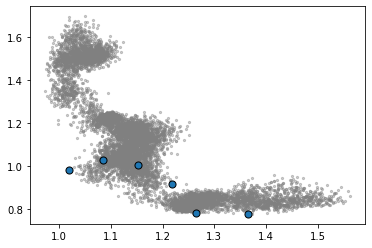

In [41]:
plt.scatter(gate_IC_dists_eff, gate_EC_dists_eff, alpha = 0.4, s = 5, color = 'grey')
plt.scatter(gate_IC_dists_eff[test_near], gate_EC_dists_eff[test_near], s = 50, edgecolor = 'black')
#plt.scatter(gate_IC_dists_eff[[0,2501,5748,8693,11802]], gate_EC_dists_eff[[0,2501,5748,8693,11802]], s = 50, edgecolor = 'black')


## lastly, for the actual figure, I want just influx apo and BFRU, one one plot or at least subplots
<a id='paper'></a>


Obviously this is repeating a lot of the things above, but just easier to have here

In [2]:
indir = '../../state_by_state_running/targeted_MD/influx_apo_all_heavy/OutOpen-InOpen'
apo = mda.Universe(f'{indir}/OUT.equilib.200ns.gro',\
                           f'{indir}/OutOpen-InOpen.TMD_only.noskip.xtc')



indir = '../../state_by_state_running/targeted_MD/influx_BFRU_all_heavy/OutOpen-InOpen'
bfru = mda.Universe(f'{indir}/OUT.equilib.200ns.BFRU.equilibrated.gro',\
                           f'{indir}/OutOpen-InOpen.xtc')

In [3]:
gate_EC = [(30,37), (289,295)]
gate_IC = [(136,145), (386,394)]

def get_tm_COM(md_uni):
    tm1 = md_uni.select_atoms('resid %i-%i' %(gate_EC[0][0], gate_EC[0][1])).center_of_mass()
    tm7 = md_uni.select_atoms('resid %i-%i' %(gate_EC[1][0], gate_EC[1][1])).center_of_mass()
    tm4 = md_uni.select_atoms('resid %i-%i' %(gate_IC[0][0], gate_IC[0][1])).center_of_mass()
    tm10 = md_uni.select_atoms('resid %i-%i' %(gate_IC[1][0], gate_IC[1][1])).center_of_mass()    

    return tm1,tm7,tm4,tm10

In [6]:
gate_EC_dists_apo = []
gate_IC_dists_apo = []

for timestep in apo.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(apo)

    gate_EC_dists_apo.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists_apo.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists_apo = np.array(gate_EC_dists_apo)
gate_IC_dists_apo = np.array(gate_IC_dists_apo)




gate_EC_dists_bfru = []
gate_IC_dists_bfru = []

for timestep in bfru.trajectory:
    tm1,tm7,tm4,tm10 = get_tm_COM(bfru)

    gate_EC_dists_bfru.append(float(distances.distance_array(tm1, tm7)) / 10)
    gate_IC_dists_bfru.append(float(distances.distance_array(tm4, tm10))/ 10) #keep in nm

    
gate_EC_dists_bfru = np.array(gate_EC_dists_bfru)
gate_IC_dists_bfru = np.array(gate_IC_dists_bfru)

In [7]:
out_open_purple = [0.35, 0.07, 0.64, 1] # [0.08,0.00,0.99,1.00]
out_occ_blue = [0.00,0.35,0.90,1.00]
occ_blue = [0.00,0.59,0.96,1.00]
in_occ_blue = [0.00,0.64,0.59,1.00]
in_open_green = [0.00,0.45,0.35,1.00]

interpolations = [
                  [4, out_open_purple, out_occ_blue], \
                  [5, out_occ_blue, occ_blue], \
                  [5, occ_blue, in_occ_blue], \
                  [5, in_occ_blue, in_open_green] 
                    ]

color_l = np.array([out_open_purple])

for i in interpolations:
    color_l = np.append(color_l, np.linspace(i[1], i[2], i[0])[1:], axis = 0)
    

np.shape(color_l)
#colors = [\"#4500E6\", \"#004BFA\", \"#0097f5\", \"#00a496\", \"#00735a\"]\

(16, 4)

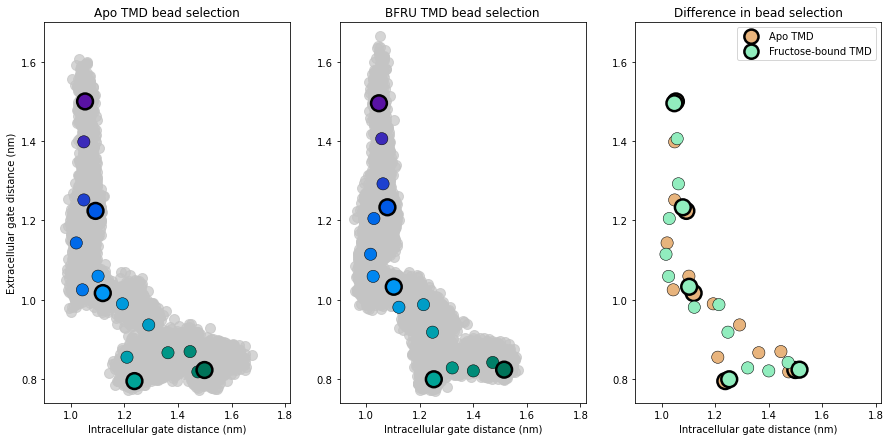

In [26]:
show_diff = True
sarah_indices_apo = [0, 2637, 5337, 7257, 9859,\
                 500, 1000, \
                 2800, 3200, 4200, \
                 5500, 5750, 6300, \
                7350, 7700, 9100]
#sarah_indices_bfru_models = [0, 2637, 5337, 7257, 9859]



sarah_indices_bfru = [0, 300, 500, 2127, \
                     2250, 3000, 3200, 4826, \
                     4900, 5000, 6300, 7985,\
                     8030, 8400, 9100, 10550]
#sarah_indices_bfru_models = [0, 2127, 4826, 7985, 10550]

lw_1 = 0.5
lw_2 = 2.5
linewidth = [lw_2, lw_1, lw_1, lw_2, lw_1, lw_1, lw_1, \
             lw_2, lw_1, lw_1, lw_1, lw_2, lw_1, lw_1, lw_1, lw_2]

lw_1 = 150
lw_2 = 250
sizes = [lw_2, lw_1, lw_1, lw_2, lw_1, lw_1, lw_1, \
             lw_2, lw_1, lw_1, lw_1, lw_2, lw_1, lw_1, lw_1, lw_2]


if show_diff:
    f, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15,7))
else:
    f, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
    

axs[0].scatter(gate_IC_dists_apo, gate_EC_dists_apo, color = '#C4C4C4', alpha = 0.7, s = 100)
axs[0].scatter(gate_IC_dists_apo[sorted(sarah_indices_apo)], gate_EC_dists_apo[sorted(sarah_indices_apo)], \
            edgecolor = 'black', s = sizes, color = color_l, linewidth = linewidth)


axs[0].set_title('Apo TMD bead selection')

axs[1].scatter(gate_IC_dists_bfru, gate_EC_dists_bfru, color = '#C4C4C4', alpha = 0.7, s = 100)
axs[1].scatter(gate_IC_dists_bfru[sorted(sarah_indices_bfru)], gate_EC_dists_bfru[sorted(sarah_indices_bfru)], \
            edgecolor = 'black', s = sizes, color = color_l, linewidth = linewidth)
axs[1].set_title('BFRU TMD bead selection')

if show_diff:
    axs[2].scatter(gate_IC_dists_apo[sorted(sarah_indices_apo)], gate_EC_dists_apo[sorted(sarah_indices_apo)],\
                  s = sizes, color = '#e8b47d', edgecolor = 'black', label = 'Apo TMD', linewidth = linewidth)
    axs[2].scatter(gate_IC_dists_bfru[sorted(sarah_indices_bfru)], gate_EC_dists_bfru[sorted(sarah_indices_bfru)],\
                  s = sizes, color = '#91edbe', edgecolor = 'black', label = "Fructose-bound TMD", linewidth = linewidth)

    axs[2].set_title('Difference in bead selection')
    axs[2].legend()
    axs[2].set_xlim(0.9,1.82)
    axs[2].set_ylim(0.74, 1.7)
    axs[2].set_xlabel("Intracellular gate distance (nm)")


axs[0].set_xlim(0.9,1.82)
axs[1].set_xlim(0.9,1.82)

axs[0].set_ylim(0.74, 1.7)
axs[1].set_ylim(0.74, 1.7)

axs[0].set_ylabel("Extracellular gate distance (nm)")
axs[0].set_xlabel("Intracellular gate distance (nm)")
axs[1].set_xlabel("Intracellular gate distance (nm)")

if show_diff:
    plt.savefig('../images_figs/TMD_bead_choice.and_diff_in_bead_choice.png', dpi = 1000)

else:
    plt.savefig('../images_figs/TMD_bead_choice.png', dpi = 1000)
